# Multivariate Gaussian HMM on example session

In [2]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files, prepro_design_matrix, concatenate_sessions
from fitting_functions import cross_validate_model
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import plot_avg_state, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, plot_states_aligned, traces_over_few_sates

one = ONE(mode='remote')

## Parameters

In [3]:
bin_size = 0.1

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'


## Data paths

In [4]:
data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
data_path_v3 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v3_1Jul2024/' + str(bin_size) + '/'
data_path_v4 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v4_5Jul2024/' + str(bin_size) + '/'

data_path = data_path_v4

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
       # var_names = ['avg_wheel_vel', 'whisker_me']
       var_names = ['avg_wheel_vel']
elif data_path == data_path_v3:
       var_names = [ 'wheel_final', 'Lick count', 'pupil_diameter', 'whisker_me',
       'left_X', 'left_Y', 'pupil_X', 'pupil_Y', 'nose_X', 'nose_Y']
       var_names = ['pupil_diameter']
elif data_path == data_path_v4:
       var_names = ['avg_wheel_vel']


# Load frame rate
fr_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/frame_rate/'
os.chdir(fr_path)
frame_rate = pickle.load(open(fr_path + "frame_rate", "rb"))


## Preprocess list of design matrices

- Each session is saved under the mouse name; concatenated with other sessions of the same mouse;
- Only data up to trial 90 is kept;
- Data is normalized and standardized

In [5]:
idxs, mouse_names = idxs_from_files(one, design_matrices, frame_rate, data_path, bin_size)
matrix_all, matrix_all_unnorm, session_all = prepro_design_matrix(one, idxs, mouse_names, 
                                                                  bin_size, var_names, data_path, first_90=True)

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.c07b94b4-18c6-4940-9bd6-9661f4ae5ceb.npy Bytes: 4600


100%|██████████| 0.00438690185546875/0.00438690185546875 [00:00<00:00,  1.86s/it]


KeyboardInterrupt: 

## Concatenate sessions of the same animal

In [ ]:
collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)

## Preprocess list of design matrices

- Each session is saved under the mouse name; concatenated with other sessions of the same mouse;
- Only data up to trial 90 is kept;
- Data is normalized and standardized

## Parameters

In [7]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'
threshold = 0.05

num_states = 4
kappa = 0

# Plotting params
bin_size = 0.1


In [8]:
for m, mat in enumerate(idxs[0:1]):
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        # mouse_name = 'CSHL060'
        session = mat[0:36]
        
        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]  
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
        " Fit model with cross-validation"
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        # Initialize model with Kmeans
        test_ghmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=kappa)
        init_params, props = test_ghmm.initialize(key=jr.PRNGKey(1), method=method, emissions=shortened_array)  # for now all data

        
        # Fit model to all data with cross-validation
        val_lls, fit_params, init_params, baseline_lls, ll_train = cross_validate_model(test_ghmm, 
                                                                              jr.PRNGKey(0), shortened_array, train_emissions, 
                                                                              method, num_train_batches)


        " Re-fit with parameters of best fold "
        # Find best fold
        use_fold = np.where(val_lls==np.nanmax(val_lls))[0][0]
        print(use_fold)
        
        # Find parameters for best fold
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_means = fit_params[2].means[use_fold]
        emission_covs = fit_params[2].covs[use_fold]
        
        # Initialize new hmm
        new_arhmm = GaussianHMM(num_states, emission_dim)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,               
                                        emission_means=emission_means,
                                        emission_covariances=emission_covs, 
                                        emissions=shortened_array)  # not sure if I need to include  
        
        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array)

        # Keep only enough states to explain 95% observations
        
        unique, counts = np.unique(most_likely_states, return_counts=True)
        threshold_count = threshold * len(most_likely_states)
        excluded_bins = 0
        remaining_states = list(counts.copy())
        for state in unique:
            size_smallest_state = np.nanmin(remaining_states)
            if size_smallest_state + excluded_bins < threshold_count:
                remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                excluded_bins += size_smallest_state
        
        # Remove states below threshold
        new_states = np.array(most_likely_states).astype(float)
        exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
        # Create a boolean mask to identify values to replace
        mask = np.isin(new_states, exclude_states)
        # Replace values in main_array with np.nan using the boolean mask
        new_states[mask] = np.nan

        new_states = most_likely_states
        
        " Plots "
        # Prepare data
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
        bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
        design_matrix_heading['Bin'] = bins
        init = -10
        end = 15
        empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, new_states, multiplier)

    
        """ Stack trial states """
        trial_init = 30  # First trial to plot
        trials_to_plot = 30  # How many trials to plot (if very different will compromise readibility)
        plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)

        " Plot states stacked and aligned per trial type "
        plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
        
        """ Plot states per trial epoch """
        colors = sns.color_palette("viridis", num_states)
        states_trial = states_per_trial_phase(empirical_data, session_trials)
        plt.figure(figsize=[7, 5])
        sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
                            multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
        plt.xlabel('Trial phase')
        plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.title(mouse_name)
        plt.show()
    
        """ Plot raw traces over states """
        init = 1500 # First bin
        inter = 400  # How long to plot
        traces_over_few_sates(init, inter, empirical_data, session_trials, var_names)


3


ValueError: Columns must be same length as key

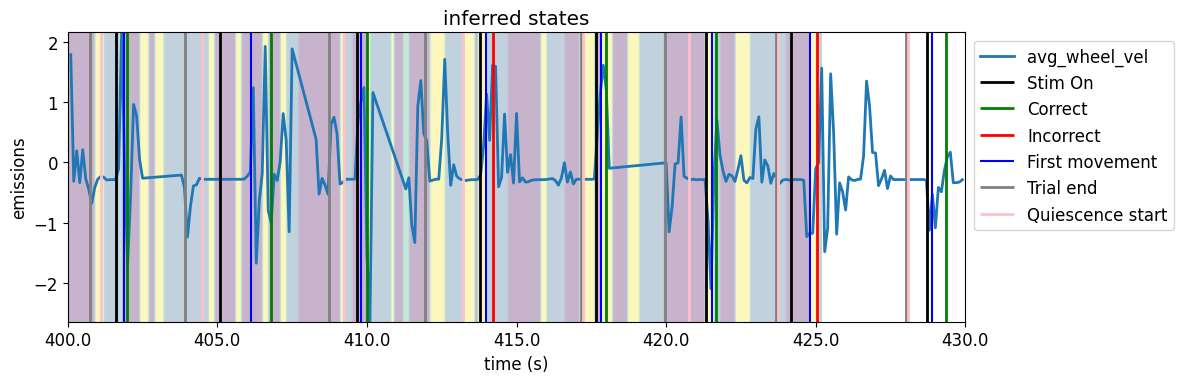

In [19]:
""" Plot raw traces over states """
init = 4000 # First bin
inter = 300
# traces_over_few_sates(init, empirical_data, session_trials, var_names)
traces_over_few_sates(init, inter, empirical_data, session_trials, var_names)


## Preprocess list of design matrices

In [4]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

### Get design matrix

Get session data for corresponding session (only one available for now)

In [2]:
# # Parameters
# bin_size = 0.1

# one = ONE()

# data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + str(bin_size) + '/'
# os.chdir(data_path)
# design_matrices = os.listdir(data_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/0.1/'

## Parameters

In [6]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'

var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']

## Preprocess list of design matrices

In [4]:
# # Save data of all sessions for latter
# matrix_all = defaultdict(list)
# session_all = defaultdict(list)

# for m, mat in enumerate(design_matrices):
   
#     # Trials data
#     session = design_matrices[m][14:-4]
#     session_trials = one.load_object(session, obj='trials', namespace='ibl')
#     session_trials = session_trials.to_df()design_matrix_names].mean()  # 
#     design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
#     design_matrix = design_matrix.dropna()
    
#     # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
#     design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
#     training_set = np.array(design_matrix[var_names]).copy() 
    
#     if len(training_set) > 0:
#       # Standardization using StandardScaler
#       scaler = StandardScaler()
#       standardized = scaler.fit_transform(training_set)
#       # Normalize between 0 and 1
#       normalizer = Normalizer().fit(standardized)
#       normalized = normalizer.transform(standardized)
      
#       # Save results
#       matrix_all[mat].append(normalized)
#       session_all[mat].append(session_trials)

2. Preprocess design matrix constructed from PCs

In [19]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/'
os.chdir(data_path)

datasets = ["design_matrix_dim_reduc_0.1"]

matrix_all_bins = defaultdict(list)

for b, binning in enumerate(datasets):
    big_design_matrix = pickle.load(open(binning, "rb"))

    design_matrix = big_design_matrix.dropna()

    # Move 
    inpt = np.array(design_matrix[['pc1', 'pc2', 'pc3', 'pc4']]).copy() # keep only first 4 PC (based on variance explained plot (see dimensionality_reduction.ipynb))
    split_parts = 5
    length = len(inpt)// split_parts * split_parts
    training_length = int(length - (length/5))
    training_set = inpt[:training_length, :]
    
    # Standardization using StandardScaler
    #scaler = StandardScaler()
    #standardized_matrix = scaler.fit_transform(inpt)

    standardized_matrix = training_set

    # Save design matrix    
    matrix_all_bins[binning].append(training_set)

## Fit optimal-state Gaussian HMM

In [5]:
num_states = 22  #This needs to be chosen manually!

# Plotting params
bin_size = 0.1
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Find best fold

Fitting session 8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


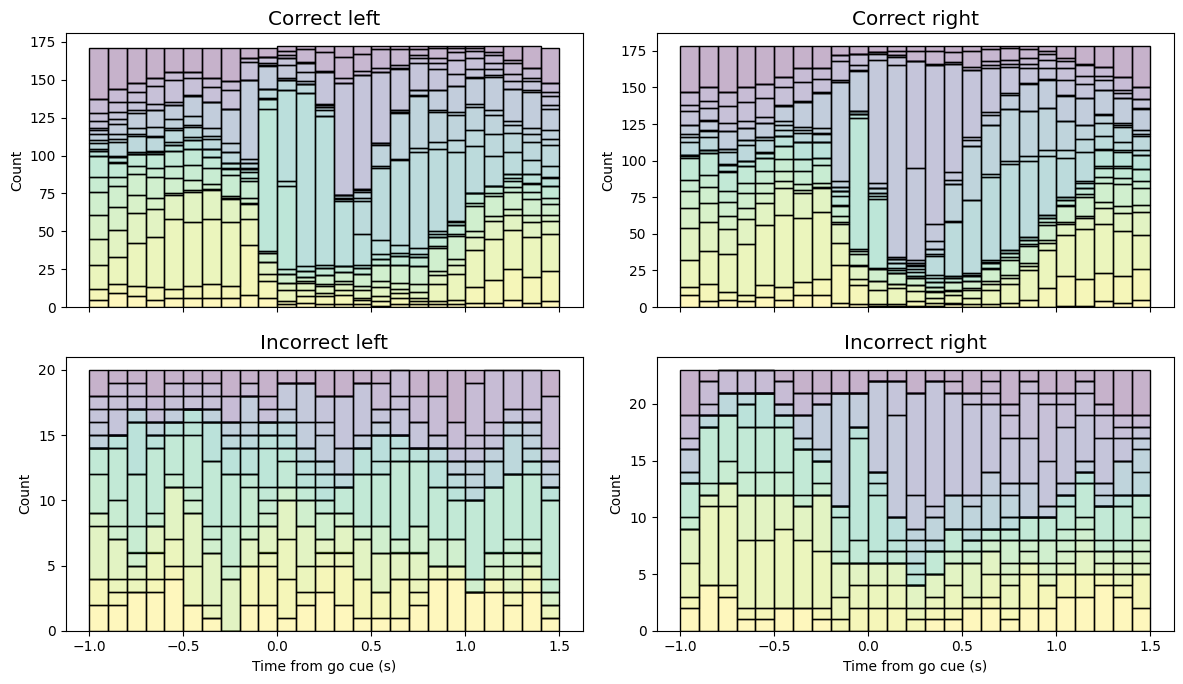

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:290: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:291: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:292: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:293: FutureWarning

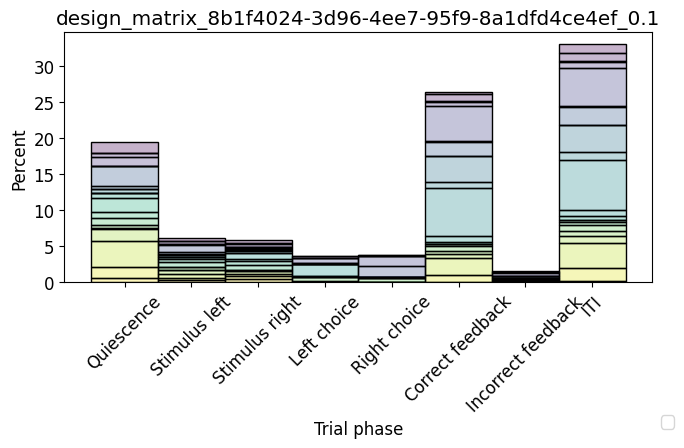

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2532: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


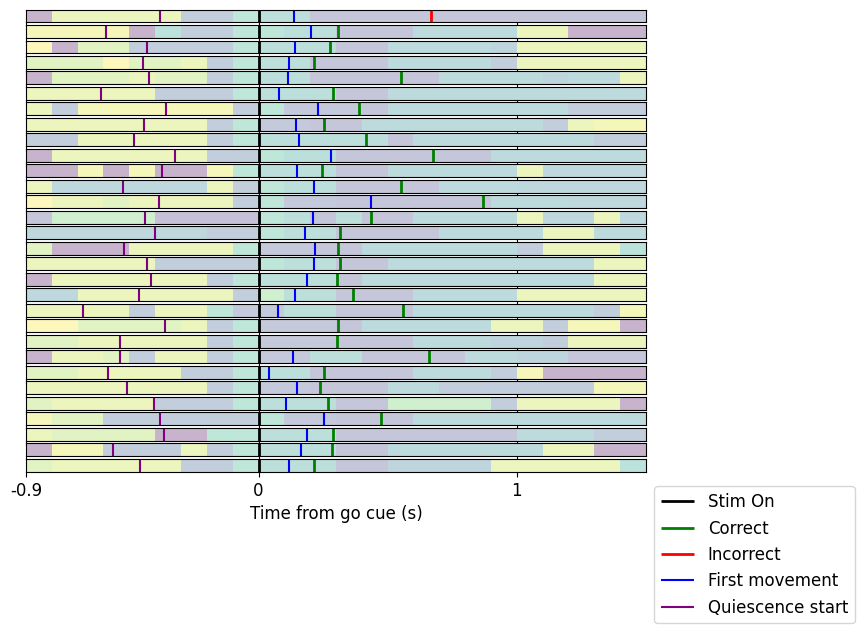

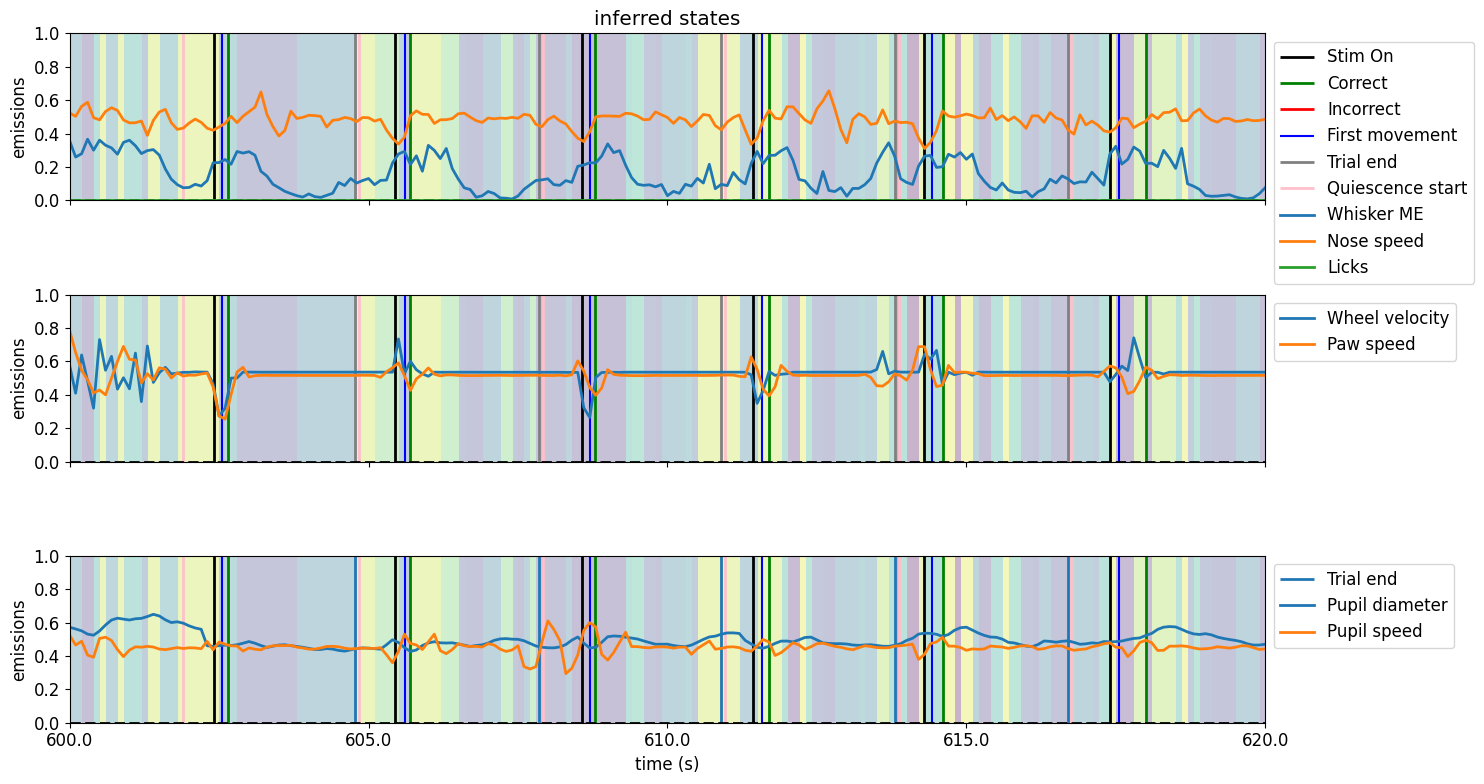

In [6]:
# Fit model for optimal number of states

for s, ses in enumerate(design_matrices[0:1]):
    #ses = 'design_matrix_d23a44ef-1402-4ed7-97f5-47e9a7a504d9_0.1'
    session_trials = session_all[ses]
    print('Fitting session ' + str(ses[14:-4]))
    
    # Trials data
    session = design_matrices[s][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(ses, "rb"))
    var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level=[0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin']<session_end*10) & (design_matrix['Bin']>session_start*10)]
    
    " Fit model "
    # Fit again (TODO: should save these results from the code above)
    num_timesteps = np.shape(matrix_all[ses][0])[0]
    emission_dim = np.shape(matrix_all[ses][0])[1]
    shortened_array = np.array(matrix_all[ses][0][:(num_timesteps // num_train_batches) * num_train_batches])
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
   
    test_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    val_lls, fit_params, init_params, baseline_lls, train_lls = cross_validate_model(test_hmm, jr.PRNGKey(0), shortened_array, train_emissions, 'kmeans', num_train_batches)

    " Find best fold (this is what Zoe does) results "
    use_fold = np.where(val_lls==np.max(val_lls))[0][0]
    print(use_fold)
        
    # Find parameters for best fold
    initial_probs = fit_params[0].probs[use_fold]
    transition_matrix = fit_params[1].transition_matrix[use_fold]
    emission_means = fit_params[2].means[use_fold]
    emission_covs = fit_params[2].covs[use_fold]
        
    # Initialize new hmm
    new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    best_fold_params, props = new_hmm.initialize(key=jr.PRNGKey(0), method=method, initial_probs=initial_probs,
                                    transition_matrix=transition_matrix,
                                    emission_means=emission_means,
                                    emission_covariances=emission_covs,
                                    emissions=matrix_all[ses][0])  # not sure if I need to include  

    # Get state estimates for validation data
    most_likely_states = new_hmm.most_likely_states(best_fold_params, matrix_all[ses][0])
    
    """ Plot frequencey of most_likely_states """
    """
    bins = np.arange(0, 100, 1)
    plt.hist(most_likely_states, bins)
    plt.xlabel('State')
    plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
    plt.ylabel('Number of bins')
    plt.title(ses)
    plt.show()
    """
    
    """ Plot states per trial type, aligned on events """
    #test_set = test_all[ses][0]
    init = -10
    end = 15
    empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix, most_likely_states, multiplier)
                                            
    plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
    
    """ Plot fit parameters """
    #states = ('State 0', "State 1", "State 2", 'State 3') 
    #states = ('State 0', 'State 1', 'State 2')
    states = []
    for s in range(num_states):
        state = 'State ' + str(s)
        states.append(state)
    
    # fig, ax = plt.subplots(ncols=len(states) , nrows=1, sharex=True, sharey=True, figsize=[20, 5])
    # plt.rc('font', size=12)

    # learned_params = params_to_df (var_names, len(states), num_train_batches, fit_params, norm_results=False)
    # for s, state in enumerate(states):
    #     use_data = learned_params.loc[learned_params['state']==s]
    #     sns.barplot(y='variable', x='value', data=use_data, ax=ax[s], palette='plasma')
    #     ax[s].vlines(0, -.50, 9.5, color='Gray', linestyles='--', linewidth=1)
    #     ax[s].set_xlabel('Mean')
    #     #ax[s].set_title(state)

    # plt.tight_layout()
    # plt.title(ses)
    # plt.show()

    """ Plot states per trial phase """
    colors = sns.color_palette("viridis", num_states)
    states_trial = states_per_trial_phase(empirical_data, session_trials)
    plt.figure(figsize=[7, 5])
    sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
                        multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
    plt.xlabel('Trial phase')
    plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(ses)
    plt.show()
    

    """ Stack trial states """
    trial_init = 100  # First trial to plot
    trials_to_plot = 30  # How many trials to plot (if very different will compromise readibility)
    plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)
    

    """ Plot raw traces over states """
    init = 6000  # First bin
    traces_over_sates(init, design_matrix, most_likely_states, session_trials, var_names)
    
    

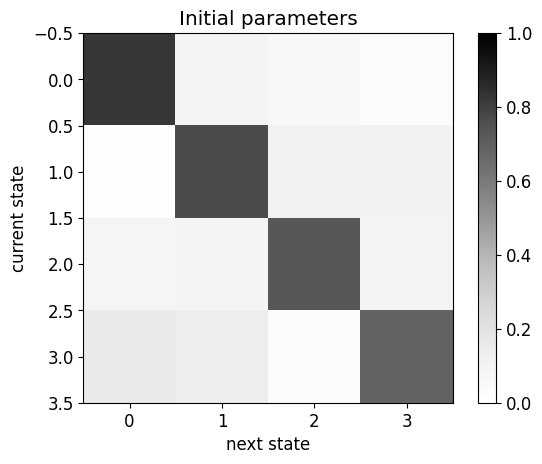

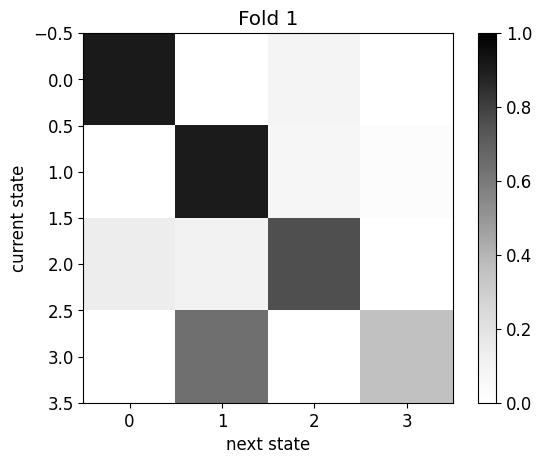

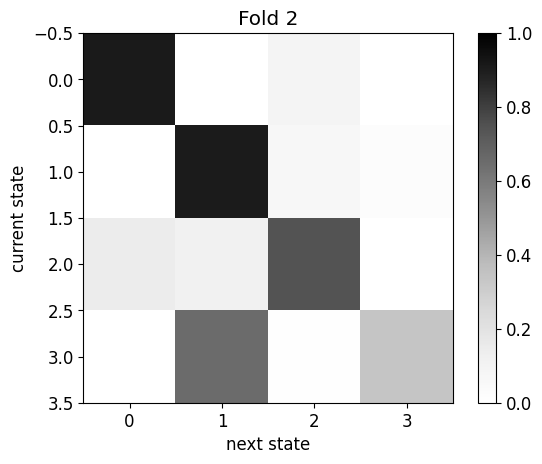

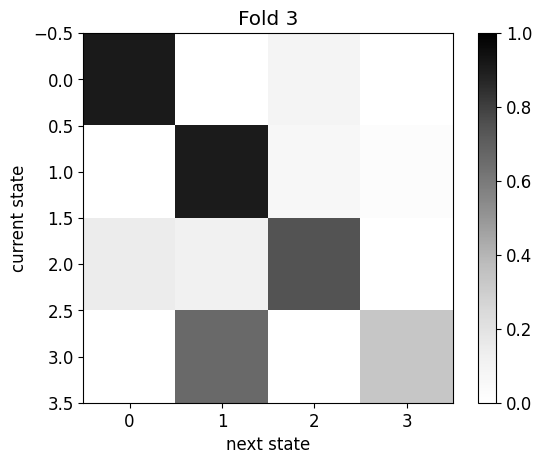

Array([[9.0734458e-01, 7.1028230e-04, 9.1937467e-02, 7.7039131e-06],
       [7.6419001e-06, 9.0575910e-01, 6.8851024e-02, 2.5382234e-02],
       [1.4591575e-01, 1.1145600e-01, 7.4253851e-01, 8.9726505e-05],
       [1.9322814e-04, 6.6256666e-01, 2.5056661e-03, 3.3473444e-01]],      dtype=float32)

In [157]:
plot_transition_mat (init_params, fit_params)

/tmp/ipykernel_46544/3566805684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


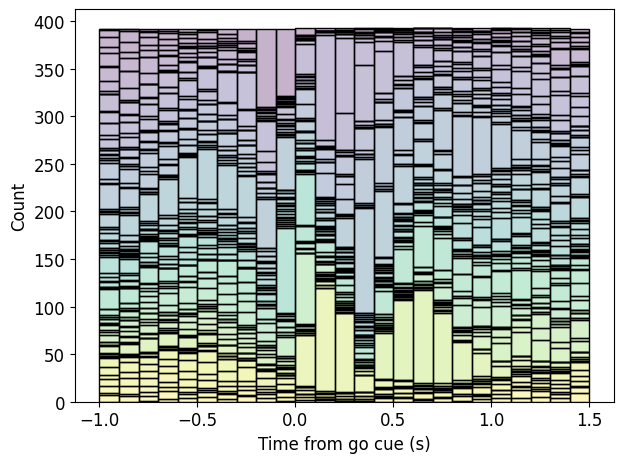

In [10]:
    # PLOT
    plt.rc('font', size=12)
    use_data = empirical_data.dropna()
    use_data['new_bin'] = use_data['new_bin'] * bin_size
    
    sns.histplot(x='new_bin', hue='most_likely_states', data=use_data, stat='count', alpha=0.3, 
                    multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, palette='viridis')

    ax.set_xlabel(str('Time from go cue (s)'))
    plt.xlabel('Time from go cue (s)')

    plt.tight_layout()
    plt.show()

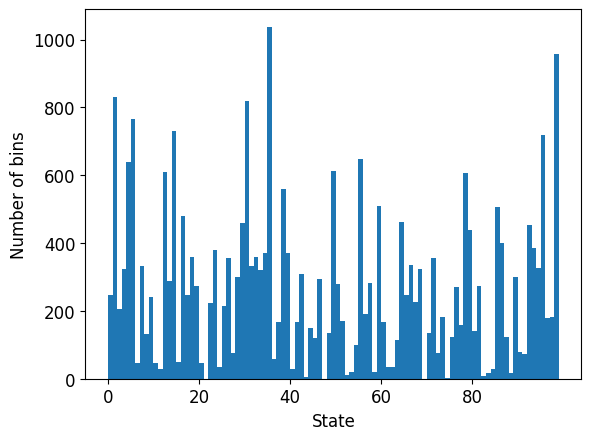

In [14]:
# TODO: order states
# Plot histogram
bins = np.arange(0, num_states, 1)
plt.hist(most_likely_states, bins)
plt.xlabel('State')
plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
plt.ylabel('Number of bins')
plt.xticks(np.arange(0, 100, 20), np.arange(0, 100, 20))
#plt.title(ses)
plt.show()

### Reduce states to represent

In [8]:
counts, _ = np.histogram(most_likely_states, bins=num_states)

In [9]:
session_length = np.sum(counts)
session_length

threshold_bins = 0.95*session_length  # minimum number of bins that the state appeared in (100 corresponds to 10 seconds on the total session)
threshold = np.ceil(session_length - threshold_bins)

threshold = 150

In [10]:
np.sum(counts>threshold)

60

In [11]:
np.sum(counts[counts>threshold])/np.sum(counts)

0.8882374906646752

In [13]:
_, remove_states = np.where([counts<threshold])

# Create a mask for values in array A that are in array B
mask = np.isin(most_likely_states, remove_states)

# Replace matching values in array A with NaN
new_states = np.array(most_likely_states, dtype=float)
new_states[mask] = np.nan


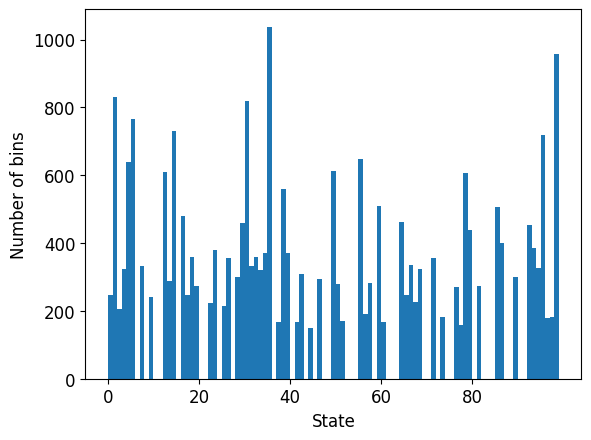

In [22]:
# Plot histogram
bins = np.arange(0, num_states, 1)
plt.hist(new_states, bins)
plt.xlabel('State')
plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
plt.ylabel('Number of bins')
plt.xticks(np.arange(0, 100, 20), np.arange(0, 100, 20))
#plt.title(ses)
plt.show()

## Plot without removed states

In [6]:
# Fit model for optimal number of states

for s, ses in enumerate(design_matrices[0:2]):
    #ses = 'design_matrix_d23a44ef-1402-4ed7-97f5-47e9a7a504d9_0.1'
    session_trials = session_all[ses]
    print('Fitting session ' + str(ses[14:-4]))
    
    # Trials data
    session = design_matrices[s][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(ses, "rb"))
    var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level=[0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin']<session_end*10) & (design_matrix['Bin']>session_start*10)]
    
    " Fit model "
    # Fit again (TODO: should save these results from the code above)
    num_timesteps = np.shape(matrix_all[ses][0])[0]
    emission_dim = np.shape(matrix_all[ses][0])[1]
    shortened_array = np.array(matrix_all[ses][0][:(num_timesteps // num_train_batches) * num_train_batches])
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
   
    test_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    val_lls, fit_params, init_params, baseline_lls, train_lls = cross_validate_model(test_hmm, jr.PRNGKey(0), shortened_array, train_emissions, 'kmeans', num_train_batches)

    " Find best fold (this is what Zoe does) results "
    use_fold = np.where(val_lls==np.max(val_lls))[0][0]
    print(use_fold)
        
    # Find parameters for best fold
    initial_probs = fit_params[0].probs[use_fold]
    transition_matrix = fit_params[1].transition_matrix[use_fold]
    emission_means = fit_params[2].means[use_fold]
    emission_covs = fit_params[2].covs[use_fold]
        
    # Initialize new hmm
    new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    best_fold_params, props = new_hmm.initialize(key=jr.PRNGKey(0), method="prior", initial_probs=initial_probs,
                                    transition_matrix=transition_matrix,
                                    emission_means=emission_means,
                                    emission_covariances=emission_covs,
                                    emissions=matrix_all[ses][0])  # not sure if I need to include  

    # Get state estimates for validation data
    most_likely_states = new_hmm.most_likely_states(best_fold_params, matrix_all[ses][0])

Fitting session 8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3
Fitting session 9b5a1754-ac99-4d53-97d3-35c2f6638507


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4
